# Find the *k* closest cell lines to each pdm model/sample

**Note!** Run this with fastai-cpu env. Otherwise, `algorithm='brute'` in kNN won't complete.

**(05-14-2018) Rick** "For each of the 1198 PDX samples (there are multiple samples for each PDX Model), compute the top 5 closest matching cell lines via the Lincs1000_combat normalized RNA-seq values. Build this similarity matrix perhaps trying a few similarity measures. Important not to use any type information when doing the $N$ closest matches. Building this matrix should be high priority."

**(05-18-2018) Rick** "I’d like the clustering results of the top $N$ (~5) cell lines for each of the PDX models. That is for each PDX model to generate the list of the 5 closest cell lines and with a **distance metric**. This file should also have the Cancer Type. Note that we need to make the Cancer type an explicit categorical value I suggest prepending “CTYPE.” to the numerical ID so that its parsed as a categorical value. This is what I’ve been doing in the robot.upload data frames."

**(05-24-2018) Judith** I worry a bit about using mean/median rnaseq gene expression values for multiple samples from PDM models. Different PDM models may have a different degree of heterogeneity in the original tumor sample and growing in mice may amplify differing subsets of that heterogeneity affecting what survives over multiple passages. I know it is more trouble but I favor looking at the expression profile from each sample from a PDM separately then seeing how much they differ and in particular how they differ or not as they are passaged through mice (since **drug experiments tend to be done on passage 3 or so**). I would then be more inclined to pick PDM models which are more “stable” across samples and passages since we do not have the expression profiles for the exact mice which receive drug treatments.  Just my two cents for what it is worth.

**(05-24-2018) Rick** Yes. Each PDX sample needs to be processed separately. Then the derived (type or otherwise) values can be combined using various methods. This is how we do response predictions as well.

### Metadata from May 2018

metadata for 15,196 samples in combined_rnaseq_data (May 1, 2018) and derivative files ordered by sample_name (and thus by data source).  

**copy_flag**=False:  data and metadata are generated from the data source.<br>
**copy_flag**=True:  both rnaseq expression values and metadata have been duplicated from either CCLE or NCI60 data/metadata.

When **sample_category** is normal or fibroblast, the tumor type is for the matching tumor sample.

columns in file are:

**sample_name** (as found in combined_rnaseq_data from Argonne ftp site dated 1 May 2018)<br>
**dataset**  (CCLE, CTRP, gCSI, GDC, GDSC, NC160, NCIPDM)<br>
**copy_flag** (false if expression data and metadata originated from dataset;  true if expression data and metadata were copied from what appears to be the same cell line in either CCLE or NCI60 datasets)<br>
**patient_id** (GDC or NCIPDM only)<br>
**specimen_id**	(NCIPDM only)<br>
**sample_id** (GDC or NCIPDM only)<br>
**core_str** (String which indicates samples which might be grouped together because they are related to the same patient tumor;  for GDC this is the patient_id; for NCIPDM it's the combination of patient_id and specimen_id that determines a **"PDM model"**;  for cell lines, it's a unique string which allows one to match the same cell line in multiple datasets)<br>
**tumor_site_from_data_src** (disease location from source of the data - in case where cell line is in both CCLE and NCI60, this is a consensus of the two)<br>
**tumor_type_from_data_src** (tumor type from source of the data - in case where cell line is in both CCLE and NCI60, this is a consensus of the two)<br>
**simplified_tumor_site** (rough attempt to consolidate tumor sites into a limited number of options)<br>
**simplified_tumor_type** (rough attempt to consolidate tumor types into a limited number of options - very similar to tumor site but takes into account types like squamous cell, which are more similar to each other than to other tumors from the same tumor site)<br>
**sample_category** (tumor, normal - GDC only, fibroblast - NCIPDM only)<br>
**sample_descr** (more detailed description of sample - for example PDX samples include passage number)<br>
**gdc_icdo_topo_code** (International Classification of Disease for Oncology topology code - GDC only)<br>
**gdc_icdo_morph_code** (International Classification of Disease for Oncology morphology code - GDC only)<br>
**stage_or_grade** (GDC: stage;  NCIPDM: grade)<br>
**hist_pct_tumor_cells** (percent tumor cells from histology - GDC, NCIPDM) --> where this data come from??<br>
**hist_pct_necrosis** (percent necrosis from histology - GDC, NCIPDM) --> where this data come from??<br>
**hist_pct_stromal** (percent stromal cells from histology - NCIPDM) --> where this data come from??<br>
**hist_pct_normal_cells** (percent normal cells from histology - GDC) --> where this data come from??<br>


J. Cohn
14 May 2018

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, 'utils_py'))
sys.path.append(utils_path)
import utils_all as utils

import warnings
warnings.filterwarnings('ignore')

SEED=0

Using TensorFlow backend.


## Load data

In [2]:
DATADIR = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
METADATA_FILENAME = 'combined_metadata_2018May.txt'
SOURCES = ['ccle', 'nci60', 'ncipdm']
lincs = utils.CombinedRNASeqLINCS(dataset='combat', datadir=DATADIR,
                                  metadata_filename=METADATA_FILENAME, sources=SOURCES)
df_rna = lincs.df_rna()
meta = lincs.meta()


Dataset: combined_rnaseq_data_lincs1000_combat
df_rna (2276, 943)
meta   (2276, 20)
NCIPDM    1198
CCLE      1018
NCI60       60
Name: Sample, dtype: int64


In [3]:
outdir_samples = os.path.join(file_path, 'knn_pdm_samples')
outdir_models = os.path.join(file_path, 'knn_pdm_models')
outdir_models_count = os.path.join(file_path, 'knn_pdm_models_count')

utils.make_dir(outdir_samples)
utils.make_dir(outdir_models)
utils.make_dir(outdir_models_count)

Explained variance by PCA components [1, 2]:  [0.14848, 0.09238]
Explained variance 0.2408657757750522


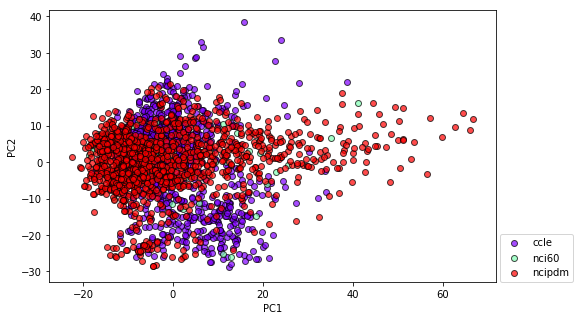

In [4]:
# Compute pca of rna
pca_obj, df_rna_pca, _ = utils.plot_pca(df_rna.iloc[:, 1:], color_vector=meta['source'], components=[1, 2]);
print('Explained variance', pca_obj.explained_variance_ratio_.sum())

In [5]:
meta[['csite', 'simplified_csite', 'ctype', 'simplified_ctype']].nunique()

csite                39
simplified_csite     15
ctype               121
simplified_ctype     17
dtype: int64

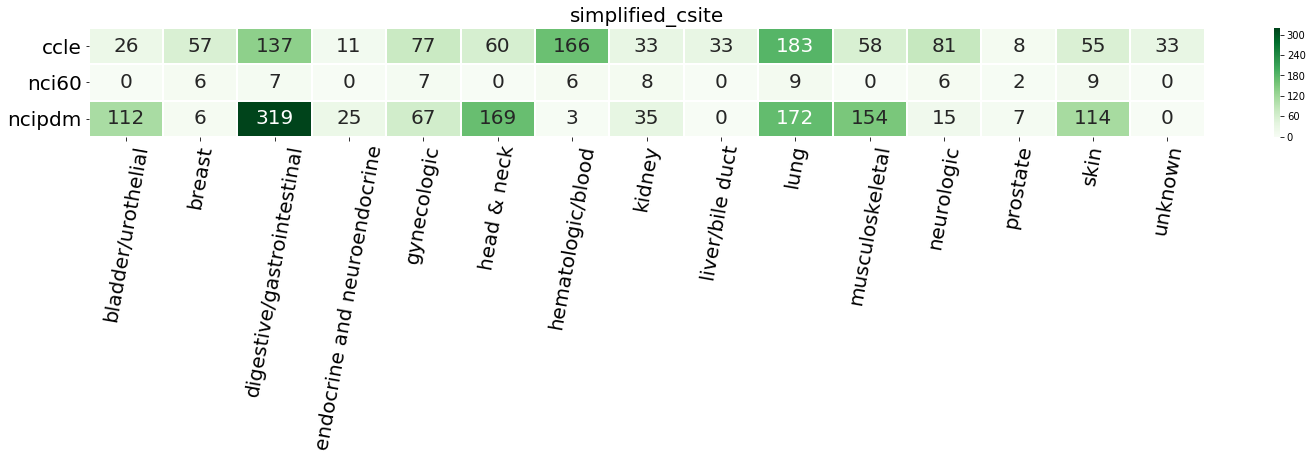

In [6]:
cols = ['source', 'simplified_csite']
tissue_table = utils.contingency_table(meta, cols=cols, title=cols[1], figsize=(25, 2))

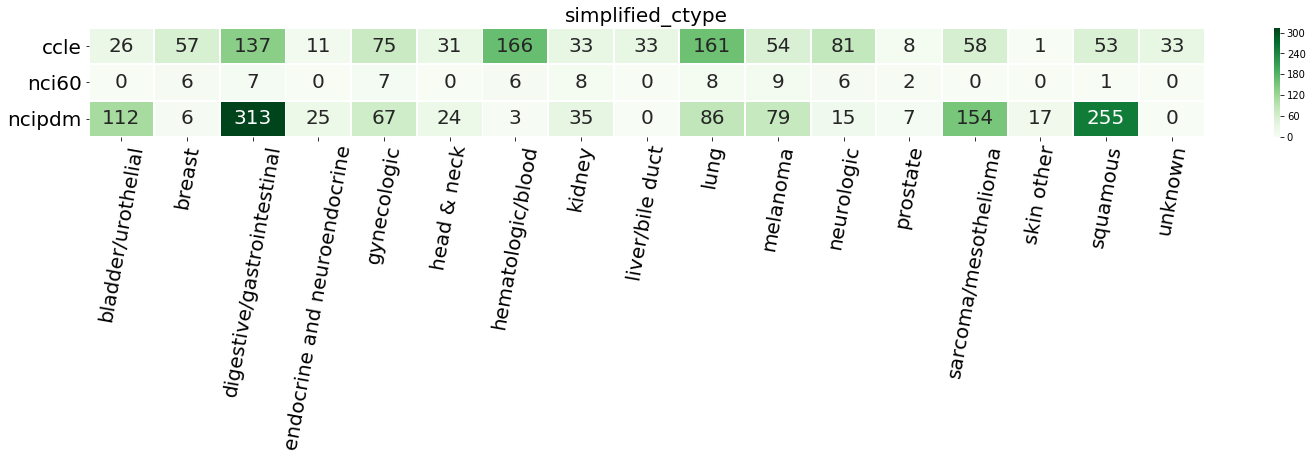

In [7]:
cols = ['source', 'simplified_ctype']
tissue_table = utils.contingency_table(meta, cols=cols, title=cols[1], figsize=(25, 2))

In [8]:
# Extract separately the pdm data, and the cell lines data
pdm_rna, pdm_meta = lincs.get_subset(sources=['ncipdm'])
cell_rna, cell_meta = lincs.get_subset(sources=['ccle', 'nci60'])
cell_meta['source'].value_counts()

ccle     1018
nci60      60
Name: source, dtype: int64

## Compute kNN for every pdm sample

In [9]:
dist_metrics_list = [('minkowski', 1), ('minkowski', 2), ('chebyshev', None), ('seuclidean', None)]
label = 'simplified_csite'
ref_col_name = 'Sample'
algorithm = 'brute'
n_neighbors = 10

In [10]:
# Use Euclidean
knn = utils.kNNrnaseq(df_train   = cell_rna,
                      meta_train = cell_meta,
                      df_test    = pdm_rna,
                      meta_test  = pdm_meta,
                      ref_col_name = ref_col_name,
                      label = label, 
                      n_neighbors = n_neighbors,
                      algorithm = algorithm,
                      metric='minkowski', p=2)
knn.fit()
knn.neighbors()
knn.summary()

Total 5990 matches out of 11980 (0.500).


In [11]:
knn.knn_samples[:2]

,Sample,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,NCIPDM.114434~197-R~A35YC3,CCLE.LN215,CCLE.HS729,CCLE.YKG1,CCLE.LN235,CCLE.SNB75,CCLE.GI1,CCLE.SKLMS1,NCI60.SNB-75,CCLE.KALS1,NCI60.SF-539
1,NCIPDM.114434~197-R~A36YC9,CCLE.HS729,CCLE.LN215,CCLE.LN235,CCLE.YKG1,CCLE.SNB75,CCLE.SW1783,CCLE.GMS10,CCLE.KALS1,CCLE.CAL78,CCLE.SF126


In [12]:
knn.knn_labels[:2]

,Sample,label,total_matches,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,NCIPDM.114434~197-R~A35YC3,musculoskeletal,2,neurologic,musculoskeletal,neurologic,neurologic,neurologic,neurologic,musculoskeletal,neurologic,neurologic,neurologic
1,NCIPDM.114434~197-R~A36YC9,musculoskeletal,2,musculoskeletal,neurologic,neurologic,neurologic,neurologic,neurologic,neurologic,neurologic,musculoskeletal,neurologic


In [13]:
# knn.knn_samples.to_csv(os.path.join(outdir_samples, 'knn_samples_euclidean.csv'), index=False)
# knn.knn_labels.to_csv(os.path.join(outdir_samples, 'knn_labels_euclidean.csv'), index=False)
# knn.knn_distances.to_csv(os.path.join(outdir_samples, 'knn_distances_euclidean.csv'), index=False)

In [14]:
# # Use multiple distance metrics
# for i, m in enumerate(dist_metrics_list):
#     print(i, m)
#     metric = dist_metrics_list[i][0]
#     if metric=='minkowski':
#         p = dist_metrics_list[i][1]
#         metric_params = None
#     else:
#         p = None
#         metric_params = dist_metrics_list[i][1]
        
#     knn_obj = kNNrnaseq(df_train = cells_rna,
#                         meta_train = cells_meta,
#                         df_test = pdm_rna,
#                         meta_test = pdm_meta,
#                         label = label, ref_col_name = ref_col_name,
#                         n_neighbors = n_neighbors, algorithm = algorithm,
#                         metric = metric, p = p, metric_params = metric_params)
#     knn_obj.fit()
#     knn_obj.neighbors()
#     print(knn_obj.table_labels['match_total'].sum())

# 1. Find tightly clustered PDM models
For each PDM model, compute the center of the model (mean or median across gene expression values). Then, for each sample within a model, compute the distance from the center. Tighter groups indicate less heterogenity in the gene expression space. We may want to focus on the tigher groups.<br>
The question is, how to compute the center? Should we use mean across genes or median?

In [15]:
# Merge PDM rna with some metadata fields
pdm = pdm_meta[['Sample', 'core_str', label, 'descr']].merge(pdm_rna.copy(), on='Sample').rename(
                columns={'core_str': 'pdm_model', label: 'label', 'descr': 'passage'})
idx = 4
pdm[:2]

,Sample,pdm_model,label,passage,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,NCIPDM.114434~197-R~A35YC3,114434~197-R,musculoskeletal,"PDX, passage 1",6.074,2.300,2.871,5.066,6.410,5.777,...,4.023,3.832,2.396,3.115,2.834,3.210,2.688,1.951,1.901,2.459
1,NCIPDM.114434~197-R~A36YC9,114434~197-R,musculoskeletal,"PDX, passage 1",6.520,2.268,2.848,5.110,6.395,5.570,...,3.482,3.725,2.340,3.350,2.896,3.553,2.740,1.846,2.268,2.508


In [16]:
# Create tables where each row corresponds to a single pdm model, and the columns are the pdm enighbors
cols = ['pdm_model'] + [f'nbr{c}' for c in range(pdm['pdm_model'].value_counts()[0])]
tb_sample   = pd.DataFrame(index=range(len(pdm['pdm_model'].unique())), columns=cols)
tb_passage  = pd.DataFrame(index=range(len(pdm['pdm_model'].unique())), columns=cols)
tb_distance = pd.DataFrame(index=range(len(pdm['pdm_model'].unique())), columns=cols)
tb_sample[:2]

,pdm_model,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
from sklearn.neighbors import NearestNeighbors
for i, model_name in enumerate(pdm['pdm_model'].unique()):
    # Extract model samples
    model_samples = pdm[pdm['pdm_model']==model_name].reset_index(drop=True)
    
    # Compute the center of the group
    center = model_samples.iloc[:, idx:].mean(axis=0)
    center = center.values[None]  # convert shape from (len(center),) to (1, len(center))
    
    # Compute the distance of the group samples to the center
    knn_model = NearestNeighbors(n_neighbors=10, algorithm='brute').fit(model_samples.iloc[:, idx:])
    dist, indices = knn_model.kneighbors(center, n_neighbors=len(model_samples))
    dist, indices = dist.ravel(), indices.ravel()
    
    tb_sample.loc[i, 'pdm_model'] = model_name
    tb_passage.loc[i, 'pdm_model'] = model_name
    tb_distance.loc[i, 'pdm_model'] = model_name

    tb_sample.iloc[i, 1:len(indices)+1] = model_samples.loc[indices, 'Sample'].values
    tb_passage.iloc[i, 1:len(indices)+1] = model_samples.loc[indices, 'passage'].values
    tb_distance.iloc[i, 1:len(indices)+1] = dist

In [18]:
tb_sample[:2]

,pdm_model,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7
0,114434~197-R,NCIPDM.114434~197-R~A38WG3J91,NCIPDM.114434~197-R~A38WG5,NCIPDM.114434~197-R~A36YC9,NCIPDM.114434~197-R~A35YC3,NCIPDM.114434~197-R~ORIGINATOR,NCIPDM.114434~197-R~A38WG0JH1,NaN,NaN
1,114551~080-T,NCIPDM.114551~080-T~M667M229C06,NCIPDM.114551~080-T~M667M226C29,NCIPDM.114551~080-T~M667M228C43,NCIPDM.114551~080-T~M676,NCIPDM.114551~080-T~M667M227C30,NaN,NaN,NaN


In [19]:
tb_passage[:2]

,pdm_model,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7
0,114434~197-R,"PDX, passage 2","PDX, passage 1","PDX, passage 1","PDX, passage 1",Patient Specimen,"PDX, passage 2",NaN,NaN
1,114551~080-T,"PDX, passage 2","PDX, passage 2","PDX, passage 2","PDX, passage 0","PDX, passage 2",NaN,NaN,NaN


In [20]:
tb_distance[:2]

,pdm_model,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7
0,114434~197-R,7.1531,7.37149,8.48998,9.52169,12.4458,14.638,NaN,NaN
1,114551~080-T,5.57337,5.99089,6.59171,7.02032,10.2527,NaN,NaN,NaN


**Larger distances from the center indicate that the pdm samples are less tight within the model.**

In [21]:
# Add the column 'label'
pdm_labels = pdm[['pdm_model', 'label']].groupby('pdm_model').agg(np.unique).reset_index()
tb_distance = pd.merge(pdm_labels, tb_distance, on='pdm_model', right_index=True)
tb_sample   = pd.merge(pdm_labels, tb_sample,   on='pdm_model', right_index=True)
tb_passage  = pd.merge(pdm_labels, tb_passage,  on='pdm_model', right_index=True)

In [22]:
# Sort rows using the mean of distances from the center.
# We're interested in pdm models with tighter groups.
# Note that certain models contain only a few samples which is misleading.
# Thus, need to remove those groups before making conclusions.
tb_distance['mean_dist'] = [tb_distance.iloc[i, 2:].dropna().mean() for i in range(tb_distance.shape[0])]
tb_distance = tb_distance.sort_values('mean_dist')
idx = tb_distance.index
tb_distance.reset_index(drop=True, inplace=True)

tb_sample = tb_sample.reindex(idx).reset_index(drop=True)
tb_passage = tb_passage.reindex(idx).reset_index(drop=True)

In [23]:
tb_sample[:2]

,pdm_model,label,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7
0,549375~167-R1,musculoskeletal,NCIPDM.549375~167-R1~fibroblast,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,223117~310-R,digestive/gastrointestinal,NCIPDM.223117~310-R~fibroblast,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
tb_passage[:2]

,pdm_model,label,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7
0,549375~167-R1,musculoskeletal,CAF Culture,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,223117~310-R,digestive/gastrointestinal,CAF Culture,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
tb_distance[:2]

,pdm_model,label,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,mean_dist
0,549375~167-R1,musculoskeletal,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,223117~310-R,digestive/gastrointestinal,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


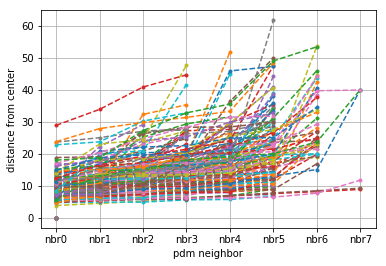

In [26]:
fig, ax = plt.subplots()
[ax.plot(tb_distance.iloc[r, 2:-1], '--.') for r in range(tb_distance.shape[0])];
plt.xlabel('pdm neighbor')
plt.ylabel('distance from center')
ax.grid()

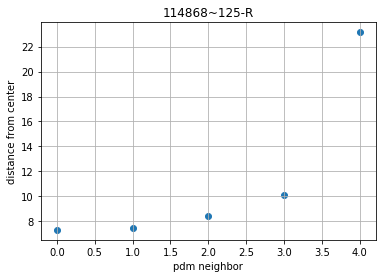

In [27]:
pdm_model = '114868~125-R'
ii = tb_distance['pdm_model']==pdm_model
y = tb_distance.loc[ii].iloc[:, 2:-1].dropna(axis=1).values.ravel()
plt.scatter(range(len(y)), y);
plt.xlabel('pdm neighbor')
plt.ylabel('distance from center')
plt.title(pdm_model)
plt.grid()

#### Outlier detection using isolation forest

In [28]:
# from sklearn.ensemble import IsolationForest
# m = IsolationForest(n_estimators=200, max_samples='auto', contamination=0.05,
#                     max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0)

# m.fit(X=rna.iloc[:, 4:].values);
# preds = m.predict(rna.iloc[:, 4:].values)

# tmp = rna[['Sample', 'model', 'label', 'passage']].copy()
# tmp.insert(loc=1, column='outlr', value=preds)

# tmp['outlr'].value_counts()
# tmp.sort_values('outlr')

# 2. Find the *k* closest cell lines for every PDM model
First, take the k (=10) closest cell lines to every PDM sample (computed above). Then we analyze each PDM model separately. Out of all the neighbors we found (k X number of pdm samples in a model), we extract a total of `total_cells_needed` cells that are the closest **to the entire pdm group**. The exact heuristic is described in the code below. Note that the heuristic favors cell lines that appear as close neighbors for multiple pdm samples as opposed to cell lines that appears very close to only a small subset of pdm samples.<br>

**This processing can be used to draw cell lines that best resemble the pdm models. Then use those cell lines to train ML models in order to make predictions on PDMs.**

In [29]:
knn_samples = knn.knn_samples.copy()
knn_distances = knn.knn_distances.copy()

In [30]:
pdm = pdm_meta[['Sample', 'core_str', label, 'descr']]
knn_samples = pdm.merge(knn_samples, on='Sample').rename(columns={'core_str': 'pdm_model', label: 'label',
                                                                  'descr': 'passage'})
knn_distances = pdm.merge(knn_distances, on='Sample').rename(columns={'core_str': 'pdm_model', label: 'label',
                                                                      'descr': 'passage'})
print(knn_distances.shape)
print(knn_samples.shape)

(1198, 14)
(1198, 14)


**The processing below will be performed for every pdm model**

In [31]:
# total_cells_needed = 10  # total number of cells to query
# model_idx = 1
# model_name = knn_samples['pdm_model'].unique()[model_idx]

# samples = knn_samples[knn_samples['pdm_model']==model_name]
# samples = samples[[c for c in samples.columns if 'nbr' in c]]

# dist = knn_distances[knn_distances['pdm_model']==model_name]
# dist = dist[[c for c in dist.columns if 'nbr' in c]]

# print('PDM model:', model_name)
# # display(samples)
# # display(dist)

# tmp = pd.DataFrame({'Sample': samples.values.ravel(), 'dist': dist.values.ravel()})
# tmp['dist'] = tmp['dist'].astype('float')  # why ravel() converts the values to `object`??
# tmp['count'] = 1
# # display(tmp[:5])

# tmp = tmp.groupby(['Sample']).agg({'dist': 'sum', 'count': 'sum'}).reset_index()
# # display(tmp)

# tmp = tmp.sort_values(['count', 'dist'], ascending=[False, True]).reset_index(drop=True)
# # display(tmp[:total_cells_needed])

**Now, analyze all the PDM models**

In [32]:
tb_samples = pd.DataFrame(index=range(len(knn_samples['pdm_model'].unique())),
                          columns=[['pdm_model'] + [f'nbr{c}' for c in range(10)]])

tb_count   = pd.DataFrame(index=range(len(knn_samples['pdm_model'].unique())),
                          columns=[['pdm_model'] + [f'nbr{c}' for c in range(10)]])
print(tb_samples.shape)
print(tb_count.shape)

(234, 11)
(234, 11)


In [33]:
total_cells_needed = 10  # total number of cells to query
for i, model_name in enumerate(knn_samples['pdm_model'].unique()):
    tb_samples.loc[i, 'pdm_model'] = model_name
    tb_count.loc[i, 'pdm_model'] = model_name
    
    # Extract the knn cell lines for all the samples of the current pdm model
    samples = knn_samples[knn_samples['pdm_model']==model_name]
    samples = samples[[c for c in samples.columns if 'nbr' in c]]

    # Extract the knn cell line distances for all the samples of the current pdm model
    dist = knn_distances[knn_distances['pdm_model']==model_name]
    dist = dist[[c for c in dist.columns if 'nbr' in c]]
    
    # 'tmp' contains a compiled list of the closest k cell lines to every pdm sample within the model
    tmp = pd.DataFrame({'Sample': samples.values.ravel(), 'dist': dist.values.ravel()})
    tmp['dist'] = tmp['dist'].astype('float')  # why ravel() converts the values to `object`??
    tmp['count'] = 1
    
    # the 'count' col contains the number of times each cell line is encountered
    tmp = tmp.groupby(['Sample']).agg({'dist': 'sum', 'count': 'sum'}).reset_index()
    # tmp = tmp.groupby(['Sample']).agg({'dist': 'mean', 'count': 'sum'}).reset_index()
    # tmp = tmp.groupby(['Sample']).agg({'dist': 'median', 'count': 'sum'}).reset_index()
    
    # sort rows by count and distance
    tmp = tmp.sort_values(['count', 'dist'], ascending=[False, True]).reset_index(drop=True)
    
    # Finally, retain the most 'significant' cell lines
    tb_samples.iloc[i, 1:] = tmp['Sample'][:total_cells_needed].values
    tb_count.iloc[i, 1:] = tmp['count'][:total_cells_needed].values

In [34]:
tb_samples[:2]

,pdm_model,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,114434~197-R,CCLE.LN215,CCLE.HS729,CCLE.YKG1,CCLE.LN235,CCLE.SNB75,CCLE.GMS10,NCI60.SNB-75,CCLE.HEKTE,CCLE.KALS1,CCLE.SKLMS1
1,114551~080-T,CCLE.ISHIKAWAHERAKLIO02ER,CCLE.LOVO,CCLE.LNCAPCLONEFGC,CCLE.LS411N,CCLE.JHUEM1,CCLE.LS180,CCLE.SNU175,CCLE.L33,CCLE.COLO320,CCLE.VCAP


In [35]:
tb_count[:2]

,pdm_model,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,114434~197-R,6,6,6,6,5,4,4,3,3,3
1,114551~080-T,5,5,5,5,5,5,5,5,4,3


In [36]:
tmp

,Sample,dist,count
0,CCLE.ECC10,207.169867,6
1,NCI60.HCT-116,212.378144,6
2,CCLE.U2OS,219.681615,6
3,CCLE.HCT116,223.263276,6
4,CCLE.SW620,223.605879,6
5,CCLE.SKUT1,185.168420,5
6,CCLE.SKNSH,187.047010,5
7,CCLE.SKNEP1,151.540023,4
8,CCLE.SW1417,111.337490,3
9,CCLE.NCIH1930,112.569320,3


In [37]:
# tb_samples.to_csv(os.path.join(outdir_models_count, 'knn_samples.csv'), index=False)
# tb_count.to_csv(os.path.join(outdir_models_count, 'knn_count.csv'), index=False)

**Note that an alternative (better?) approach is to remove pdm outlier samples before executing the processing above.**

# 3. Find the best PDM models in terms of kNN results
This processing generates a table that is sorted based by the best PDM models in terms of knn results with cell lines. This table can be used following section 2 in order to choose what models to focus on.

In [118]:
knn_samples   = knn.knn_samples.copy()
knn_labels    = knn.knn_labels.copy()
knn_distances = knn.knn_distances.copy()

In [119]:
pdm = pdm_meta[['Sample', 'core_str', label, 'descr']]
knn_samples = pdm.merge(knn_samples, on='Sample').rename(columns={'core_str': 'pdm_model', label: 'label',
                                                                  'descr': 'passage'})
knn_labels = pdm.merge(knn_labels, on='Sample').rename(columns={'core_str': 'pdm_model', label: 'label',
                                                                'descr': 'passage'})
knn_distances = pdm.merge(knn_distances, on='Sample').rename(columns={'core_str': 'pdm_model', label: 'label',
                                                                      'descr': 'passage'})
print(knn_samples.shape)
print(knn_labels.shape)
print(knn_distances.shape)

(1198, 14)
(1198, 16)
(1198, 14)


In [120]:
knn_labels    = knn_labels.sort_values(by=['total_matches', 'pdm_model'], ascending=False)
knn_samples   = knn_samples.reindex(knn_labels.index)
knn_distances = knn_distances.reindex(knn_labels.index)

In [121]:
knn_labels.reset_index(drop=True, inplace=True)
knn_samples.reset_index(drop=True, inplace=True)
knn_distances.reset_index(drop=True, inplace=True)

In [122]:
knn_labels[:2]

,Sample,pdm_model,label,passage,label,total_matches,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,NCIPDM.LG0703~F948~M2M110M230M345M428,LG0703~F948,lung,"PDX, passage 4",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung
1,NCIPDM.LG0703~F948~M3M218M339,LG0703~F948,lung,"PDX, passage 2",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung


In [123]:
knn_samples[:2]

,Sample,pdm_model,label,passage,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,NCIPDM.LG0703~F948~M2M110M230M345M428,LG0703~F948,lung,"PDX, passage 4",CCLE.NCIH3255,CCLE.HCC2935,CCLE.NCIH2291,CCLE.SW900,CCLE.HCC4006,CCLE.RERFLCAD1,CCLE.HCC1171,CCLE.NCIH1648,CCLE.NCIH1781,CCLE.LCLC97TM1
1,NCIPDM.LG0703~F948~M3M218M339,LG0703~F948,lung,"PDX, passage 2",CCLE.HCC2935,CCLE.NCIH3255,CCLE.NCIH2291,CCLE.SW900,CCLE.HCC4006,CCLE.HCC1171,CCLE.RERFLCAD1,CCLE.NCIH1648,CCLE.NCIH596,CCLE.NCIH441


In [124]:
knn_distances[:2]

,Sample,pdm_model,label,passage,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,NCIPDM.LG0703~F948~M2M110M230M345M428,LG0703~F948,lung,"PDX, passage 4",31.4985,31.5981,33.2251,33.2467,34.1039,34.3476,34.5217,34.8797,34.9172,34.9332
1,NCIPDM.LG0703~F948~M3M218M339,LG0703~F948,lung,"PDX, passage 2",34.6534,35.0858,36.9824,37.4084,37.6331,37.8001,38.0806,38.2997,38.3378,38.5009


In [125]:
# i, model_name = 2, table_samples['model'].unique()[2]
# tmp = table_labels[table_labels['model']==model_name]

In [126]:
ss = pd.DataFrame(index=range(len(knn_samples['pdm_model'].unique())),
                  columns=['pdm_model', 'samples', 'matches', 'nunique', 'dist'])
print(ss.shape)
ss[:3]

(234, 5)


,pdm_model,samples,matches,nunique,dist
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


In [128]:
for i, model_name in enumerate(knn_samples['pdm_model'].unique()):
    ss.loc[i, 'pdm_model'] = model_name
    
    # Extract the knn cell lines labels for all the samples of the current pdm model
    tmp = knn_labels[knn_labels['pdm_model']==model_name]
    ss.loc[i, 'samples'] = len(tmp)  # total pdm samples in the model
    ss.loc[i, 'matches'] = tmp['total_matches'].mean()  # mean of matches

    # Extract the knn cell lines for all the samples of the current pdm model    
    tmp = knn_samples[knn_samples['pdm_model']==model_name]
    tmp = tmp[[c for c in tmp.columns if 'nbr' in c]]
    ss.loc[i, 'nunique'] = len(np.unique(tmp.values.ravel()))  # total unique cell line neighbors
    
    # Extract the knn cell line distances for all the samples of the current pdm model
    tmp = knn_distances[knn_distances['pdm_model']==model_name]
    tmp = tmp[[c for c in tmp.columns if 'nbr' in c]]
    # ss.loc[i, 'dist'] = np.sum(tmp.values.ravel())/(10*len(tmp))
    ss.loc[i, 'dist'] = tmp.values.ravel().mean()  # mean distance

In [133]:
ss = ss.sort_values(['matches', 'nunique'], ascending=[False, True]).reset_index(drop=True)
ss[:10]

,pdm_model,samples,matches,nunique,dist
0,638129~119-R,5,10,13,27.767
1,199195~117-R,4,10,13,27.9181
2,128128~338-R,6,10,13,29.9137
3,515677~202-R,6,10,19,35.349
4,714841~288-R,6,9.83333,19,30.3973
5,519858~162-T,6,9.83333,21,28.3309
6,186277~243-T,4,9.75,13,25.3956
7,158597~082-R,4,9.75,14,27.1742
8,CN0330~F216,6,9.66667,19,27.4664
9,563396~261-R,6,9.66667,20,31.8129


In [137]:
# Let's see the top PDM model
# We can see a perfect match in terms of the tissue/cancer type (all cell neighbros
# are of the same type as the pdm model)
knn_labels[knn_labels['pdm_model']==ss.loc[0,'pdm_model']]

,Sample,pdm_model,label,passage,label,total_matches,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
47,NCIPDM.638129~119-R~CP5Y41,638129~119-R,lung,"PDX, passage 1",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung
48,NCIPDM.638129~119-R~CP6,638129~119-R,lung,"PDX, passage 0",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung
49,NCIPDM.638129~119-R~CP7,638129~119-R,lung,"PDX, passage 0",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung
50,NCIPDM.638129~119-R~CP7GP0,638129~119-R,lung,"PDX, passage 1",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung
51,NCIPDM.638129~119-R~CP8GL4,638129~119-R,lung,"PDX, passage 1",lung,10,lung,lung,lung,lung,lung,lung,lung,lung,lung,lung


In [138]:
tmp = knn_samples.groupby(['pdm_model'], as_index=False).agg({'label': 'unique',
                                                      'nbr0': 'unique', 'nbr1': 'unique', 'nbr2': 'unique',
                                                      'nbr3': 'unique', 'nbr4': 'unique', 'nbr5': 'unique',
                                                      'nbr6': 'unique', 'nbr7': 'unique', 'nbr8': 'unique',
                                                      'nbr9': 'unique',
                                                     })

In [139]:
tmp['label'] = tmp['label'].map(lambda x: x[0])
tmp

,pdm_model,label,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,114434~197-R,musculoskeletal,"[CCLE.LN215, CCLE.HS729, CCLE.HEKTE]","[CCLE.HS729, CCLE.LN215, CCLE.YKG1]","[CCLE.YKG1, CCLE.LN235, NCI60.SF-539]","[CCLE.LN235, CCLE.YKG1, CCLE.HS729, CCLE.SNB75]","[CCLE.SNB75, CCLE.SKLMS1, CCLE.GMS10]","[CCLE.GI1, CCLE.SW1783, CCLE.LN235, NCI60.SNB-...","[CCLE.SKLMS1, CCLE.GMS10, CCLE.YKG1, CCLE.OELE...","[NCI60.SNB-75, CCLE.KALS1, CCLE.OC314, CCLE.GM...","[CCLE.KALS1, CCLE.CAL78, CCLE.HOP62, CCLE.HEKT...","[NCI60.SF-539, CCLE.SF126, CCLE.SLR20, CCLE.GI..."
1,114551~080-T,head & neck,"[CCLE.LNCAPCLONEFGC, CCLE.LOVO, CCLE.ISHIKAWAH...","[CCLE.LOVO, CCLE.LNCAPCLONEFGC]","[CCLE.JHUEM1, CCLE.LS411N, CCLE.LNCAPCLONEFGC,...","[CCLE.ISHIKAWAHERAKLIO02ER, CCLE.JHUEM1, CCLE....","[CCLE.LS411N, CCLE.SNU175, CCLE.JHUEM1]","[CCLE.SNU175, CCLE.JHUEM1, CCLE.LS180, CCLE.L33]","[CCLE.LS180, CCLE.L33, CCLE.SNU175, CCLE.COLO320]","[CCLE.L33, CCLE.LS180, CCLE.SNU175]","[CCLE.CORL105, CCLE.VCAP, CCLE.COLO320, CCLE.S...","[CCLE.CL34, CCLE.COLO320, CCLE.VCAP, CCLE.CADO..."
2,114868~125-R,head & neck,"[CCLE.SF767, CCLE.RERFLCMS]","[CCLE.BICR18, CCLE.TE9, CCLE.OELE]","[CCLE.TE9, CCLE.BICR18, CCLE.SNB75]","[CCLE.TE11, CCLE.KYSE510, CCLE.SNU46]","[CCLE.SNU503, CCLE.NCIH1975]","[CCLE.HARA, CCLE.FADU, CCLE.JHUEM3]","[CCLE.TE15, CCLE.FADU, CCLE.HCC2814, CCLE.NCIH...","[CCLE.KYSE510, CCLE.PECAPJ34CLONEC12, CCLE.HCC...","[CCLE.FADU, CCLE.KYSE510, CCLE.TE11, CCLE.TE15...","[CCLE.A253, CCLE.T3M4, CCLE.HCC95, CCLE.RERFLC..."
3,116653~092-T,gynecologic,"[CCLE.NCIH2085, CCLE.HCC1143, CCLE.NCIH1650, C...","[CCLE.HEKTE, CCLE.HCC38, CCLE.NCIH1650, CCLE.H...","[CCLE.OC314, NCI60.EKVX, CCLE.NCIH1650, CCLE.N...","[CCLE.DU145, CCLE.HCC1171, CCLE.HCC1143, NCI60...","[CCLE.SNU840, CCLE.NCIH1650, CCLE.HCC1171, NCI...","[CCLE.SNU8, CCLE.NCIH1975, CCLE.HEKTE, NCI60.E...","[CCLE.NCIH1650, CCLE.SNU840, CCLE.DU145, CCLE....","[CCLE.RERFLCAI, CCLE.NCIH2085, CCLE.HCC1143, C...","[CCLE.HCC1171, CCLE.HCC1954, CCLE.NCIH1975, CC...","[CCLE.NCIH1975, CCLE.EFO27, CCLE.OC314, CCLE.H..."
4,116653~108-T,gynecologic,"[CCLE.LOVO, CCLE.HEKTE, CCLE.HCC38, CCLE.HCC19...","[NCI60.DU-145, CCLE.NCIH1650, CCLE.MDAMB468, C...","[NCI60.MDA-MB-468, CCLE.DU145, CCLE.NCIH1568, ...","[CCLE.HeLa, CCLE.647V, CCLE.HCC1937, CCLE.DU14...","[CCLE.HEKTE, CCLE.RERFLCAI, CCLE.HCC1143, CCLE...","[CCLE.OC314, CCLE.HeLa, NCI60.EKVX, CCLE.NCIH2...","[CCLE.JHUEM1, CCLE.OC314, CCLE.MDAMB468, CCLE....","[CCLE.SF767, CCLE.NCIH1975, CCLE.HCC1171, CCLE...","[CCLE.RERFLCAI, CCLE.NCIH2085, CCLE.HCC1954, N...","[CCLE.JHOS2, CCLE.CAL851, CCLE.HCC70, CCLE.647..."
5,117519~064-T,prostate,"[CCLE.LNCAPCLONEFGC, CCLE.VCAP, NCI60.HCT-15]","[CCLE.VCAP, CCLE.MDAPCA2B, CCLE.LNCAPCLONEFGC,...","[CCLE.MDAPCA2B, CCLE.VCAP, CCLE.22RV1]","[CCLE.22RV1, CCLE.MDAMB361, CCLE.MDAPCA2B, CCL...","[CCLE.MDAMB361, CCLE.22RV1, NCI60.PC-3, CCLE.P...","[NCI60.PC-3, CCLE.SNUC2A, CCLE.OC314, NCI60.DU...","[CCLE.SNUC2A, CCLE.SNUC4, CCLE.LOVO, NCI60.LOX...","[CCLE.LS180, NCI60.PC-3, CCLE.OC314, NCI60.NCI...","[CCLE.NCIH1048, CCLE.LS180, CCLE.639V, CCLE.LS...","[CCLE.NCIH1373, CCLE.NCIH1568, NCI60.HCT-116, ..."
6,126254~015-R,musculoskeletal,"[CCLE.HS888T, CCLE.WM793, CCLE.HS729, CCLE.HS683]","[CCLE.RPMI7951, CCLE.HS888T, CCLE.CH157MN, CCL...","[CCLE.YH13, CCLE.RPMI7951, CCLE.HOP62, CCLE.HS...","[CCLE.HS751T, CCLE.HS683, CCLE.HS229T, CCLE.SW...","[CCLE.TCCSUP, CCLE.HS751T, CCLE.SF126, CCLE.TI...","[CCLE.HS739T, CCLE.HS343T, CCLE.RERFLCAI, CCLE...","[CCLE.TO175T, CCLE.HS840T, CCLE.SW1088, CCLE.C...","[CCLE.T173, CCLE.YH13, CCLE.OELE, CCLE.GAMG, C...","[CCLE.NHA, CCLE.TIG3TD, CCLE.U178, CCLE.HS840T]","[CCLE.HS600T, CCLE.HS729, CCLE.SNU423, CCLE.SF..."
7,128128~338-R,skin,"[CCLE.HS936T, CCLE.SKMEL30, CCLE.MELHO]","[CCLE.MELHO, CCLE.HS936T, NCI60.UACC-257, CCLE...","[CCLE.SKMEL5, CCLE.MELHO, CCLE.HS936T, CCLE.UA...","[CCLE.SKMEL30, CCLE.IGR37, NCI60.SK-MEL-5, NCI...","[NCI60.UACC-257, CCLE.SKMEL5, CCLE.HS936T, CCL...","[CCLE.IGR37, NCI60.M14, CCLE.UACC257, C

## Compute kNN for every PDM sample - averaged across multiple distance metrics

#### Long running time!

In [23]:
# knn_results = knn_for_single_rna_summary(cells_rna, cells_meta,
#                                          pdm_rna, pdm_meta,
#                                          label='simplified_csite',
#                                          n_neighbors=n_neighbors,
#                                          algorithm=algorithm)
# knn_samples, knn_labels, knn_distances = knn_results
# print(knn_labels['match_total'].sum())

1/1198: NCIPDM.114434~197-R~A35YC3
101/1198: NCIPDM.172845~121-B~M770J03J74
201/1198: NCIPDM.227169~078-T~JN4K38
301/1198: NCIPDM.286954~287-R~Z86
401/1198: NCIPDM.381576~328-R~J30M844
501/1198: NCIPDM.471365~239-R~FB5P21
601/1198: NCIPDM.592915~224-R~A96AZ4IF8
701/1198: NCIPDM.695221~133-T~VV9M19
801/1198: NCIPDM.765638~272-R~AG2I09
901/1198: NCIPDM.889142~216-R~T53TC4
1001/1198: NCIPDM.969956~357-R~CNNUN3
1101/1198: NCIPDM.LG0476~F007~M25M102M223M334
5788


In [24]:
# knn_samples.to_csv(os.path.join(outdir_samples, 'knn_samples_averaged.csv'), index=False)
# knn_labels.to_csv(os.path.join(outdir_samples, 'knn_labels_averaged.csv'), index=False)
# knn_distances.to_csv(os.path.join(outdir_samples, 'knn_distances_averaged.csv'), index=False)

## Compute kNN for every PDM model
Here the gene expression values within the same model are averaged (mean/median) across the PDM samples. This appraoch is not preferable because PDM samples within the same model can be very heterogeneous. A better appraoch is the one described in section 2 above.

https://stackoverflow.com/questions/77936/whats-the-best-way-to-calculate-a-3d-or-n-d-centroid

In [25]:
# For every pdm model compute a single rna expression
# m_rna, m_meta, pdm_model_names = gen_single_rna_for_each_pdm_model(pdm_rna, pdm_meta)

Total number of unique pdm models: 234
m_meta.shape (234, 5)
m_rna.shape (234, 943)


In [26]:
# label = 'simplified_csite'
# ref_col_name = 'Sample'
# algorithm = 'brute'
# n_neighbors = 10

In [27]:
# Use Euclidean
# knn_obj = kNNrnaseq(df_train   = cells_rna,
#                     meta_train = cells_meta,
#                     df_test    = m_rna,
#                     meta_test  = m_meta,
#                     label = label, ref_col_name = ref_col_name,
#                     n_neighbors = n_neighbors, algorithm = algorithm,
#                     metric = 'minkowski', p = 2)
# knn_obj.fit()
# knn_obj.neighbors()
# print(knn_obj.table_labels['match_total'].sum())

1196


In [28]:
# Rename back 'Sample' into 'Model'
# m_meta.rename(columns={'Sample': 'Model'}, inplace=True)
# m_rna.rename(columns={'Sample': 'Model'}, inplace=True)

# table_labels = knn_obj.table_labels.copy()
# table_labels.rename(columns={'Sample': 'Model'}, inplace=True)
# table_samples = knn_obj.table_samples.copy()
# table_samples.rename(columns={'Sample': 'Model'}, inplace=True)
# table_distances = knn_obj.table_distances.copy()
# table_distances.rename(columns={'Sample': 'Model'}, inplace=True)

# table_samples = table_samples.reindex(table_labels.index)
# table_labels['match_total'].value_counts()

In [29]:
# table_samples.to_csv(os.path.join(outdir_models, 'knn_samples.csv'), index=False)
# table_labels.to_csv(os.path.join(outdir_models, 'knn_labels.csv'), index=False)
# table_distances.to_csv(os.path.join(outdir_models, 'knn_distances.csv'), index=False)

## Compute kNN for every pdm model - averaged across multiple distance metrics

#### Iter over pdm models and compute kNN for using difrenet distnaces metrics

In [30]:
# For every pdm model compute a single rna expression
# m_rna, m_meta = gen_single_rna_for_each_pdm_model(pdm_rna, pdm_meta)

Total number of unique pdm models: 234
m_meta.shape (234, 5)
m_rna.shape (234, 943)


In [31]:
# knn_results = knn_for_single_rna_summary(cells_rna, cells_meta,
#                                          m_rna, m_meta,
#                                          label='simplified_csite',
#                                          n_neighbors = n_neighbors, algorithm = algorithm)
# knn_samples, knn_labels, knn_distances = knn_results
# print(knn_labels['match_total'].sum())

1/234: 114434~197-R
101/234: 466732~252-T
201/234: 999852~294-R
1166


In [32]:
# Rename back 'Sample' into 'Model'
# m_meta.rename(columns={'Sample': 'Model'}, inplace=True)
# m_rna.rename(columns={'Sample': 'Model'}, inplace=True)

# table_labels = knn_obj.table_labels.copy()
# table_labels.rename(columns={'Sample': 'Model'}, inplace=True)
# table_samples = knn_obj.table_samples.copy()
# table_samples.rename(columns={'Sample': 'Model'}, inplace=True)
# table_distances = knn_obj.table_distances.copy()
# table_distances.rename(columns={'Sample': 'Model'}, inplace=True)

# table_samples = table_samples.reindex(table_labels.index)
# table_labels['match_total'].value_counts()

In [33]:
# table_samples.to_csv(os.path.join(outdir_models, 'knn_samples_averaged.csv'), index=False)
# table_labels.to_csv(os.path.join(outdir_models, 'knn_labels_averaged.csv'), index=False)
# table_distances.to_csv(os.path.join(outdir_models, 'knn_distances_averaged.csv'), index=False)

## Find Yvonne's models in our predictions

In [140]:
tmp = pd.read_csv('yvonne_models.txt', sep='\t', header=None).rename(columns={0: 'Sample'})
models = tmp['Sample'].values

In [141]:
models

array(['172845-121-T', '235635-245-T', '245127-232-R', '252836-082-R',
       '283339-068-R', '327498-153-R', '594176-295-R', '743489-274-T',
       '767577-098-T', '779769-127-R', '845751-090-R', '997537-175-T',
       '997726-040-R', 'BL0293-F563', 'BL0382-F1232', 'BL0479-F1894',
       'CN0375-F725', 'CN0446-F447', 'LG0481-F231', 'LG0520-F434',
       'LG0556-F006', 'LG0567-F671', 'LG0703-F948', 'LG1011-PE1607',
       'LG1049-F1704', 'LG1189-F1952'], dtype=object)

In [143]:
def func(x, models):
    xx = x.split('.')[-1].replace('~', '-')
    val = np.bool(sum([True if m in xx else False for m in models]))
    return val

In [144]:
idx = knn_samples['Sample'].map(lambda x: func(x, models) )

In [145]:
knn_samples = knn_samples[idx].reset_index(drop=True)
knn_distances = knn_distances[idx].reset_index(drop=True)
knn_labels = knn_labels[idx].reset_index(drop=True)

In [146]:
knn_samples[:10]

,Sample,pdm_model,label,passage,nbr0,nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8,nbr9
0,NCIPDM.LG0703~F948~M2M110M230M345M428,LG0703~F948,lung,"PDX, passage 4",CCLE.NCIH3255,CCLE.HCC2935,CCLE.NCIH2291,CCLE.SW900,CCLE.HCC4006,CCLE.RERFLCAD1,CCLE.HCC1171,CCLE.NCIH1648,CCLE.NCIH1781,CCLE.LCLC97TM1
1,NCIPDM.LG0703~F948~M3M218M339,LG0703~F948,lung,"PDX, passage 2",CCLE.HCC2935,CCLE.NCIH3255,CCLE.NCIH2291,CCLE.SW900,CCLE.HCC4006,CCLE.HCC1171,CCLE.RERFLCAD1,CCLE.NCIH1648,CCLE.NCIH596,CCLE.NCIH441
2,NCIPDM.LG0567~F671~M16M121M210,LG0567~F671,lung,"PDX, passage 2",CCLE.NCIH2347,CCLE.HCC78,CCLE.SW900,CCLE.NCIH1975,CCLE.HCC1171,CCLE.HCC827,CCLE.SQ1,CCLE.NCIH647,CCLE.NCIH2291,CCLE.RERFLCAD1
3,NCIPDM.LG0567~F671~M17,LG0567~F671,lung,"PDX, passage 0",CCLE.HCC1171,CCLE.RERFLCAD1,CCLE.NCIH1975,CCLE.SW900,CCLE.HCC827,CCLE.NCIH2347,CCLE.NCIH2009,CCLE.NCIH2087,CCLE.NCIH2291,CCLE.LCLC97TM1
4,NCIPDM.LG0567~F671~M17M111M201,LG0567~F671,lung,"PDX, passage 2",CCLE.HCC1171,CCLE.RERFLCAD1,CCLE.NCIH1975,CCLE.HCC827,CCLE.NCIH2087,CCLE.SW900,CCLE.LCLC97TM1,CCLE.NCIH441,CCLE.NCIH1373,CCLE.NCIH2347
5,NCIPDM.LG0567~F671~M18M125M220,LG0567~F671,lung,"PDX, passage 2",CCLE.HCC1171,CCLE.RERFLCAD1,CCLE.NCIH2291,CCLE.NCIH1975,CCLE.NCIH441,CCLE.NCIH2347,CCLE.SW900,CCLE.LCLC97TM1,CCLE.NCIH2087,CCLE.HCC827
6,NCIPDM.CN0375~F725~M61M177M564,CN0375~F725,digestive/gastrointestinal,"PDX, passage 2",CCLE.SNU283,CCLE.T84,CCLE.CL34,CCLE.SNU61,CCLE.LOVO,CCLE.SW1463,CCLE.LS411N,CCLE.HCC56,CCLE.LS180,CCLE.SNUC4
7,NCIPDM.CN0375~F725~M61M177M565,CN0375~F725,digestive/gastrointestinal,"PDX, passage 2",CCLE.SNUC4,CCLE.LS180,CCLE.CL34,CCLE.GP2D,CCLE.LS411N,CCLE.SNUC5,CCLE.T84,CCLE.LOVO,CCLE.SNU283,CCLE.HT29
8,NCIPDM.CN0375~F725~tumor,CN0375~F725,digestive/gastrointestinal,Mixed Cell Culture,CCLE.SNUC5,CCLE.CL11,CCLE.LOVO,CCLE.SW1417,CCLE.SW837,CCLE.LS180,CCLE.LS1034,CCLE.NCIH747,CCLE.CL34,CCLE.CL14
9,NCIPDM.997537~175-T~HN1G62,997537~175-T,digestive/gastrointestinal,"PDX, passage 1",CCLE.SNUC4,CCLE.LS411N,CCLE.LOVO,CCLE.LS180,CCLE.CL34,CCLE.HCT15,CCLE.SNUC5,CCLE.SNU407,NCI60.HCT-116,CCLE.CW2


In [50]:
# knn_samples.to_csv('subset_knn_samples.csv', index=False)
# knn_distances.to_csv('subset_knn_distances.csv', index=False)
# knn_labels.to_csv('subset_knn_labels.csv', index=False)